In [1]:
## Data Manipulation
import pandas as pd
import numpy as np
import xmltodict
import json

## Scraping
import io
import requests
from bs4 import BeautifulSoup as bs

## Plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Spatial Manipulation
import geopandas as gpd
from shapely.geometry import Point

## Mapping
import folium
from folium import plugins

## Misc
import time
import datetime
from ipypb import track
from IPython.display import JSON

In [3]:
map_url = 'https://www.londonair.org.uk/london/asp/XML/SiteDetailsXml.asp'

map_params = {
    'mapview' : 'All',
    'IncClosed' : 'Y',
}

map_r = requests.get(map_url, params=map_params)

map_r

<Response [200]>

In [4]:
def map_response_2_gdf(r):
    ## Parsing xml to df
    df_locs = pd.DataFrame(xmltodict.parse(r.text)['markers']['marker'])
    
    ## Cleaning columns
    df_locs.columns = df_locs.columns.str.replace('@', '')
    numeric_cols = ['lat', 'lng', 'latoffset', 'lonoffset']
    df_locs[numeric_cols] = df_locs[numeric_cols].astype(float)
    
    ## Converting to spatial df
    geometry = [Point(xy) for xy in zip(df_locs['lng'], df_locs['lat'])]
    gdf_locs = gpd.GeoDataFrame(df_locs, geometry=geometry)
    
    return gdf_locs

gdf_locs = map_response_2_gdf(map_r)

gdf_locs.head()

,lat,lng,html,label,network,type,latoffset,lonoffset,code,geometry
0,51.668643,-0.022007,publicdetails.asp?site=EN7&Maptype=Google&mapv...,Enfield - Prince of Wales School,LAQN,Urban Background,0.0,0.0,EN7,POINT (-0.02201 51.66864)
1,51.652436,-0.084225,publicdetails.asp?site=EN2&Maptype=Google&mapv...,Enfield - Church Street,LAQN,Roadside,0.0,0.0,EN2,POINT (-0.08422 51.65244)
2,51.645037,-0.066180,publicdetails.asp?site=EN1&Maptype=Google&mapv...,Enfield - Bush Hill Park,LAQN,Suburban,0.0,0.0,EN1,POINT (-0.06618 51.64504)
3,51.637479,-0.044246,publicdetails.asp?site=EN3&Maptype=Google&mapv...,Enfield - Salisbury School,LAQN,Urban Background,0.0,0.0,EN3,POINT (-0.04425 51.63748)
4,51.625193,-0.022597,publicdetails.asp?site=WL3&Maptype=Google&mapv...,Waltham Forest - Chingford,LAQN,Roadside,-300.0,-300.0,WL3,POINT (-0.02260 51.62519)


In [5]:
## Initialising map with custom tiles
m = folium.Map([51.5, -0.1], zoom_start=10, tiles='cartodbpositron') # <- Same tile they use in their map

## Plotting the heatmap
sensor_heatmap = folium.FeatureGroup(name='Heat Map')
sensors = gdf_locs[['lat', 'lng']].values
plugins.HeatMap(sensors, radius=20).add_to(sensor_heatmap)

## Plotting the annotated points
sensor_locations = folium.FeatureGroup(name='Sensors')
for x, y, label in gdf_locs[['lat', 'lng', 'label']].dropna().values:
    folium.CircleMarker(location=(x, y), radius=1, fill=True, color='black', tooltip=label).add_to(sensor_locations)
  
## Defining layers
sensor_heatmap.add_to(m)
sensor_locations.add_to(m)

m

In [10]:
def retrieve_select_options(soup, name):
    options = soup.find('select', {'name':name}).findAll("option")

    option_values = [option.get('value') for option in options]
    option_text = [option.text for option in options]

    option_val_2_text = dict(zip(option_values, option_text))
    
    return option_val_2_text

def soup_2_data_options(soup):
    species_options = retrieve_select_options(soup, 'species')
    site_options = retrieve_select_options(soup, 'site')

    for dict_ in [species_options, site_options]:
        dict_.pop(None)

    data_options = {
        'species' : species_options,
        'sites' : site_options,
    }
    
    return data_options

downloads_url = 'https://www.londonair.org.uk/london/asp/datadownload.asp'

r = requests.get(downloads_url)
soup = bs(r.text)
data_options = soup_2_data_options(soup)

## Saving and visualising the JSON data
with open('data/site_options.json', 'w') as fp:
    json.dump(data_options, fp)

JSON(data_options)

<IPython.core.display.JSON object>

In [11]:
## Identifying closed sensors/schools <- Need to clarify what 'closed' refers to
s_sites = pd.Series(data_options['sites'])
s_closed_bool = s_sites.str.contains('closed')
s_open_sites = s_sites[~s_closed_bool]

## Determining percentage that are closed
pct_sites_closed = s_closed_bool.mean()
print(f'{round(100*pct_sites_closed, 1)}% of the sites are currently closed')

s_open_sites.head()

51.0% of the sites are currently closed


BG1        Barking and Dagenham - Rush Green
BG2    Barking and Dagenham - Scrattons Farm
BX2                       Bexley - Belvedere
BX0                  Bexley - Belvedere FDMS
BQ7                  Bexley - Belvedere West
dtype: object

In [12]:
## Show example params and query with response, then move onto proper wrapper

In [13]:
def parse_dt(raw_dt):
    dt_type_2_timestamp = {
        pd.Timestamp : lambda dt: dt,
        str : lambda dt: pd.to_datetime(dt),
        datetime.date : lambda dt: pd.to_datetime(dt),
    }
    
    assert type(raw_dt) in dt_type_2_timestamp.keys(), f"Datetime datatype must be one of: {', '.join([repr(type_) for type_ in dt_type_2_timestamp.keys()])}"

    timestamp_dt = dt_type_2_timestamp[type(raw_dt)](raw_dt)
    parsed_dt = timestamp_dt.strftime('%d-%b-%Y').lower().lstrip('0')
    
    return parsed_dt

date_example_types = [pd.to_datetime('2019-10-01'), '2019-10-01', datetime.date(2019, 10, 1)]
parsed_dts = []

for date_example_type in date_example_types:
    parsed_dt = parse_dt(date_example_type)
    parsed_dts += [parsed_dt]
    
parsed_dts

['1-oct-2019', '1-oct-2019', '1-oct-2019']

In [14]:
def get_date_params(start_dt, end_dt):
    date_params = {
        'start' : parse_dt(start_dt),
        'end' : parse_dt(end_dt),
    }
    
    return date_params

start_dt = '2020-01-01'
end_dt = '2020-05-16'

date_params = get_date_params(start_dt, end_dt)

date_params

{'start': '1-jan-2020', 'end': '16-may-2020'}

In [15]:
def get_site_params(sites):
    assert len(sites) <= 6, 'No more than 6 sites can be specified'

    site_params = dict()

    for site_num, site_id in enumerate(sites):
        assert site_id in data_options['sites'].keys(), f'{site_id} is not contained in the list of accepted sites'

        site_params_entry = {f'site{site_num+1}' : site_id}
        site_params.update(site_params_entry)

    return site_params

sites = ['BG1', 'BG2', 'BX2', 'BX0', 'BQ7']

get_site_params(sites)

{'site1': 'BG1',
 'site2': 'BG2',
 'site3': 'BX2',
 'site4': 'BX0',
 'site5': 'BQ7'}

In [16]:
class LAQN():
    def __init__(self):
        self.url = 'https://www.londonair.org.uk/london/asp/downloadspecies.asp'
        
        with open('data/site_options.json', 'r') as fp:
            data_options = json.load(fp)
            self.species = data_options['species']
            self.sites = data_options['sites']
        
    response_2_df = lambda self, r: pd.read_csv(io.StringIO(r.content.decode('utf-8')))
    
    def parse_dt(self, raw_dt):
        dt_type_2_timestamp = {
            pd.Timestamp : lambda dt: dt,
            str : lambda dt: pd.to_datetime(dt),
            datetime.date : lambda dt: pd.to_datetime(dt),
        }

        assert type(raw_dt) in dt_type_2_timestamp.keys(), f"Datetime datatype must be one of: {', '.join([repr(type_) for type_ in dt_type_2_timestamp.keys()])}"

        timestamp_dt = dt_type_2_timestamp[type(raw_dt)](raw_dt)
        parsed_dt = timestamp_dt.strftime('%d-%b-%Y').lower().lstrip('0')

        return parsed_dt
    
    def get_date_params(self, start_dt, end_dt):
        date_params = {
            'start' : self.parse_dt(start_dt),
            'end' : self.parse_dt(end_dt),
        }

        return date_params
    
    def get_site_params(self, sites):
        assert len(sites) <= 6, 'No more than 6 sites can be specified'

        site_params = dict()

        for site_num, site_id in enumerate(sites):
            assert site_id in self.sites.keys(), f'{site_id} is not contained in the list of accepted sites'

            site_params_entry = {f'site{site_num+1}' : site_id}
            site_params.update(site_params_entry)

        return site_params

    def query(self, sites, species, start_dt, end_dt):
        assert species in self.species.keys(), f"{species} is not contained in the list of accepted species:\n{', '.join(self.species.keys())}"
        
        params = {
            'species' : species,
            'res' : '6',
            'period' : '15min',
            'units' : '',
        }
        
        site_params = self.get_site_params(sites)
        params.update(site_params)
        
        date_params = self.get_date_params(start_dt, end_dt)
        params.update(date_params)

        r = requests.get(self.url, params=params)
        df = self.response_2_df(r)
        
        return df
    
LAQN_scraper = LAQN()

sites = ['BG1', 'BG2', 'BX2', 'BX0', 'BQ7']
species = 'NO2'
start_dt = '2020-04-01'
end_dt = '2020-04-10'

df = LAQN_scraper.query(sites, species, start_dt, end_dt)

df.head()

,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified
0,BG1,NO2,01/04/2020 00:00,8.4,ppb,P
1,BG1,NO2,01/04/2020 00:15,8.4,ppb,P
2,BG1,NO2,01/04/2020 00:30,11.5,ppb,P
3,BG1,NO2,01/04/2020 00:45,NaN,ppb,P
4,BG1,NO2,01/04/2020 01:00,NaN,ppb,P


In [17]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]
        
species_list = ['NO2']
sites = ['CD9']

years = list(range(2015, 2020))
site_batches = list(batch(sites, 6))

df = pd.DataFrame()
failed_queries = []

for species in species_list:
    for sites in site_batches:
        for year in track(years, label=', '.join(sites)):
            try:
                start_dt = f'{year}-01-01'
                end_dt = f'{year+1}-01-01'

                df_query = LAQN_scraper.query(sites, species, start_dt, end_dt)
                df = df.append(df_query)

            except:
                failed_queries += [(sites, year)]

            time.sleep(0.5)

            CD9 [█████████████████████████████████████████████] 5/5 [00:29<00:04, 5.77s/it]

In [18]:
for sites in site_batches:
    for year in track([2020], label=', '.join(sites)):
        try:
            start_dt = f'{year}-01-01'
            end_dt = f'{year+1}-04-10'

            df_query = LAQN_scraper.query(sites, species, start_dt, end_dt)
            df = df.append(df_query)
            
        except:
            failed_queries += [(sites, year)]

        time.sleep(0.5)

            CD9 [█████████████████████████████████████████████] 1/1 [00:02<00:02, 1.82s/it]

In [19]:
def clean_df(df):
    df_clean = (df
                .copy()
                [~df['Value'].isnull()]
                .drop_duplicates()
                .pivot('ReadingDateTime', 'Site', 'Value')
               )
    
    df_clean.index = pd.to_datetime(df_clean.index, format='%d/%m/%Y %H:%M')
    
    return df_clean
    
df_clean = clean_df(df)

df_clean.head()

Site,CD9
ReadingDateTime,
2015-01-01 00:00:00,54.3
2015-01-01 00:15:00,44.7
2015-01-01 00:30:00,52.7
2015-01-01 00:45:00,60.8
2015-01-01 01:00:00,66.9


Text(0.5, 1.0, 'Euston Road Emissions - NO$_{2}$ (ppb)')

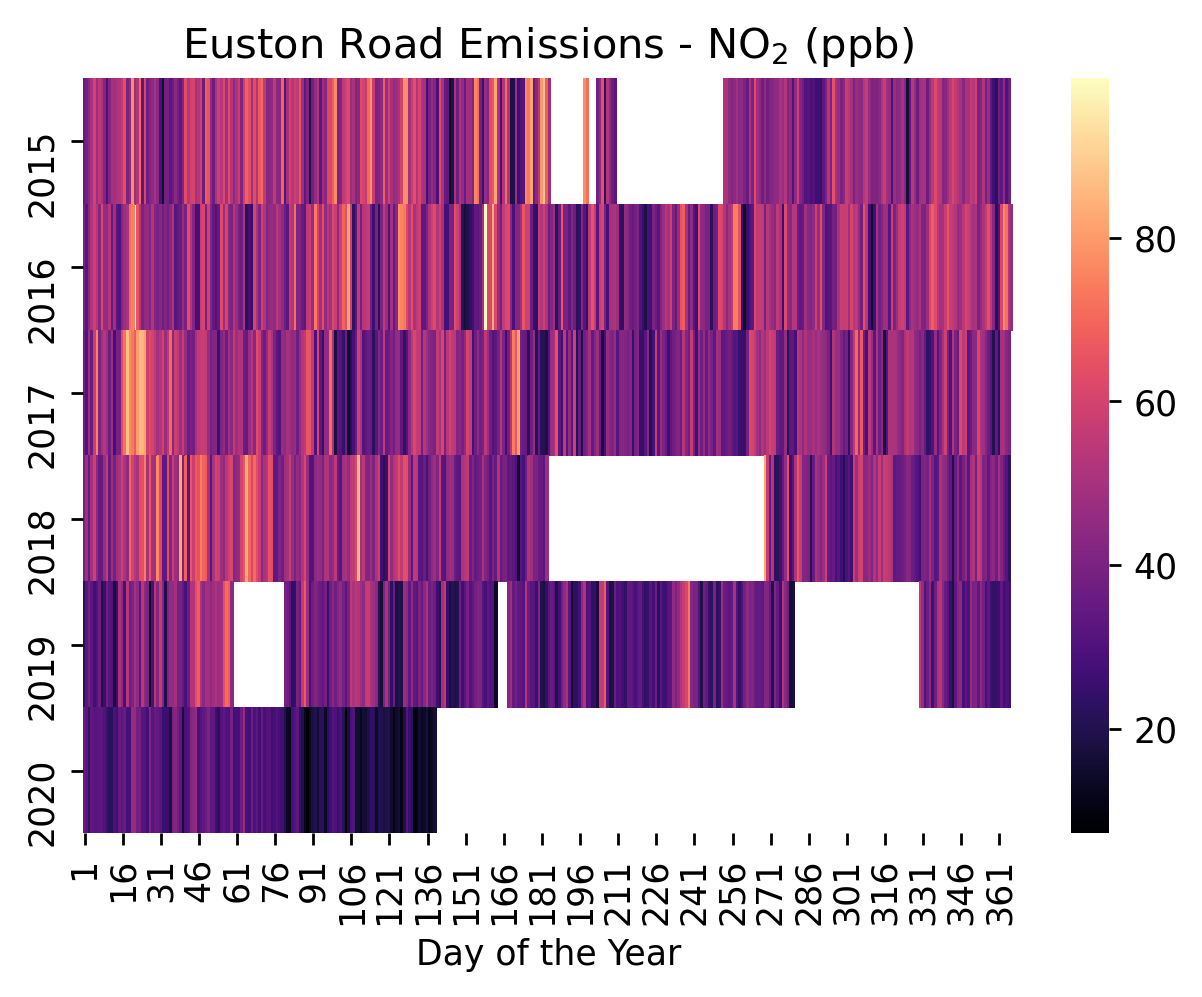

In [20]:
site_id = 'CD9' # 'BL0' <- Camden

df_euston_daily_mean = (df_clean
                        [site_id]
                        .groupby([df_clean.index.year.values, 
                                  df_clean.index.dayofyear.values])
                        .mean()
                        .reset_index()
                        .rename(columns={'level_0':'year', 
                                         'level_1':'DoY'})
                        .pivot('year', 'DoY', site_id)
                       )

## Plotting
fig, ax = plt.subplots(dpi=250)

sns.heatmap(df_euston_daily_mean, cmap='magma', ax=ax)

ax.set_xlabel('Day of the Year')
ax.set_ylabel('')
ax.set_title('Euston Road Emissions - NO$_{2}$ (ppb)')

Text(0.5, 1.0, '')

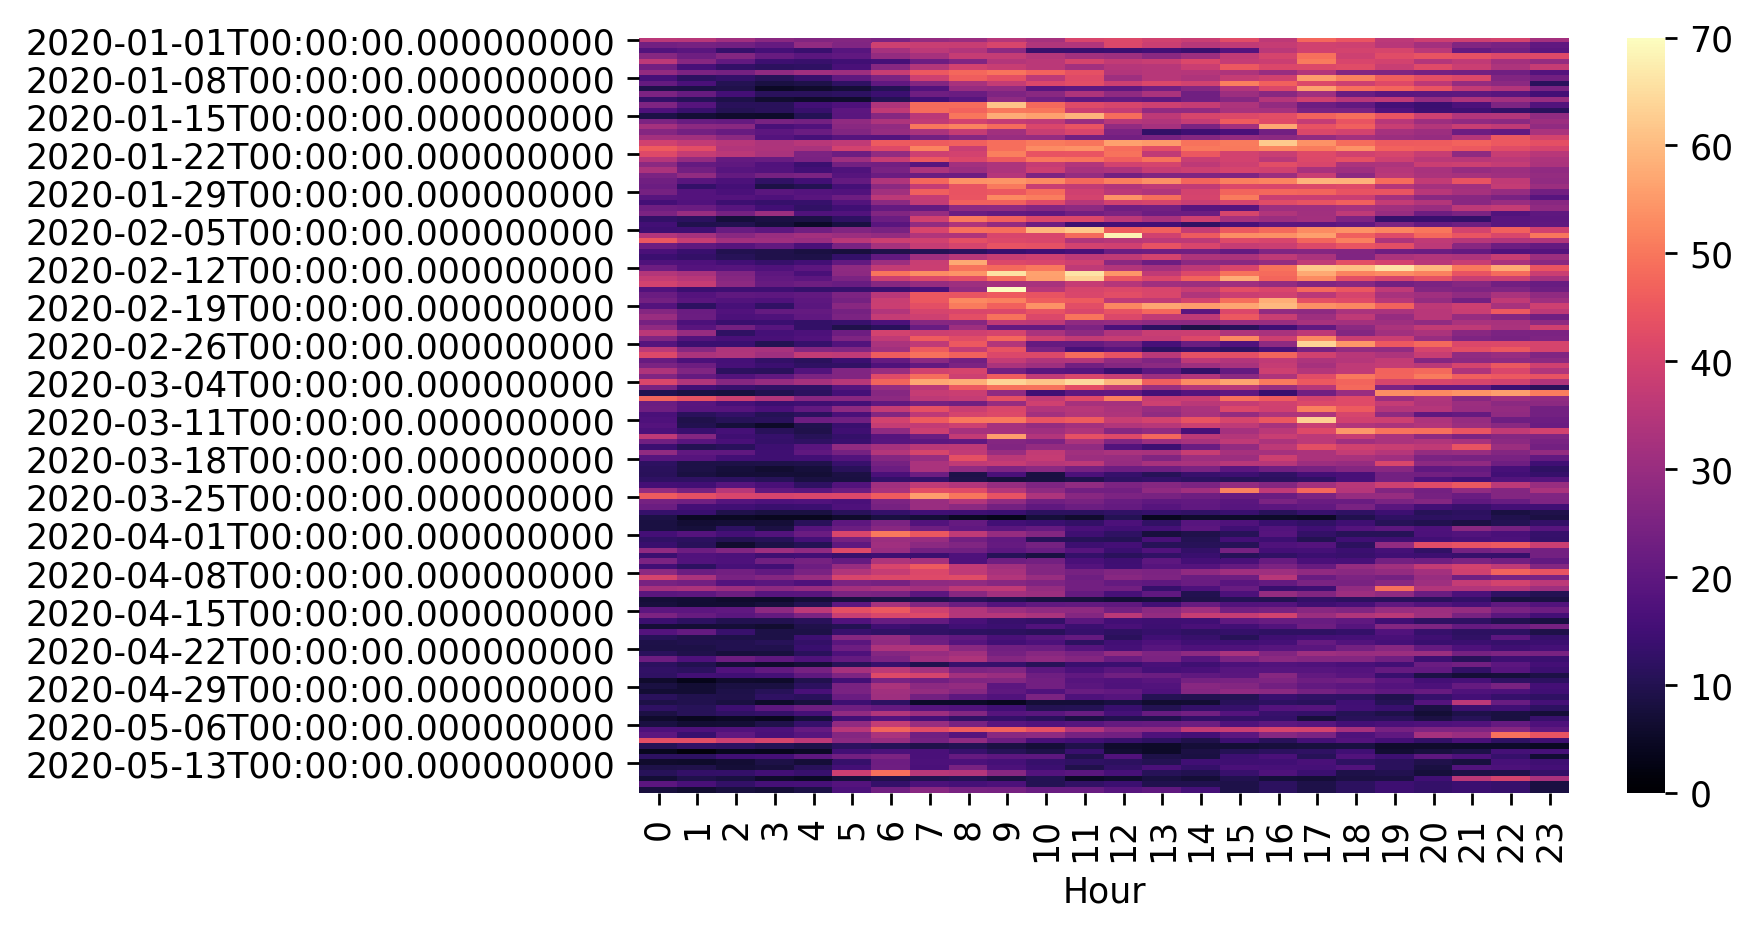

In [21]:
s_emissions = df_clean[site_id].resample('H').mean().copy()

df_emissions_pivot = (s_emissions
                      .copy()
                      .groupby([s_emissions.index.hour, 
                                s_emissions.index.date])
                      .mean()
                      .reset_index()
                      .rename(columns={'ReadingDateTime':'hour', 
                                       'level_1':'date', 
                                       'CD9':'NO2'})
                      .pivot('date', 'hour', 'NO2')
                     )

df_emissions_pivot.index = pd.to_datetime(df_emissions_pivot.index)
df_emissions_pivot.interpolate().interpolate(axis=1).to_pickle('data/emissions.pkl')

vis_start_date = '2020-01-01'

## Plotting
fig, ax = plt.subplots(dpi=250)

sns.heatmap(df_emissions_pivot[vis_start_date:].interpolate().interpolate(axis=1), ax=ax, vmin=0, vmax=70, cmap='magma')

ax.set_xlabel('Hour')
ax.set_ylabel('')
ax.set_title('')